**Brian Blaylock**  
**May 31, 2019**

# How Fractions Skill Score (FSS) works

Hopefully this helps explain what FSS is, how is is calculated, and the meaning of a useful forecast.

FSS was introduced by Nigel Roberts and Humphrey Lean in 2008. It is a verification method that describes skill between forecasts and observed binary conditions as a fraction of area within a neighborhood.

> Roberts, N.M. and H.W. Lean, 2008: Scale-Selective Verification of Rainfall Accumulations from High-Resolution Forecasts of Convective Events. Mon. Wea. Rev., 136, 78–97, https://doi.org/10.1175/2007MWR2123.1

## 1. Convert to binary fields
Generate two grids of binary fields, 1) where the conditon was observed and 2) where the condition was forecasted.

## 2. Generate Fractions
You need to determine a scale to evaluate with grid points within a neighborhood (*n*). The easiest neighborhood is a square, but you may also use a circular neighborhood.

For _every_ grid point in the observed and forecasted binary field, consider all the points within the neighborhood and compute the fraction of points where the condintion is met. This will create two new fields ranging in values of 0 to 1.

- `O(n)i,j` is the field of fractions for the observed binary field with neighborhood _n_.
- `M(n)i,j` is the field of fractions for the forecasted binary field with neighborhood _n_.

This computation can easily be applied to every grid point with `scipy.ndimage.generic_filter`

    import scipy.ndimage as ndimage
    
    def fraction(values):
        return np.sum(values)/np.size(values)
     
     obs_fraction = ndimage.generic_filter(obs_binary, fraction, mode='constant', cval=0, size=5) 
     fxx_fraction = ndimage.generic_filter(fxx_binary, fraction, mode='constant', cval=0, size=5) 

For example, below are the observed and forecasted binary fields for a neighborhood of 5 X 5.

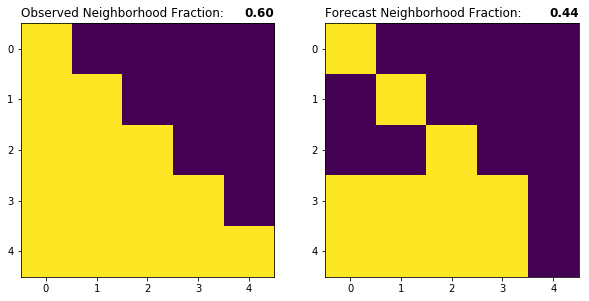

In [111]:
# Binary observation for neighborhood
OBS_n = [[1,0,0,0,0],
         [1,1,0,0,0],
         [1,1,1,0,0],
         [1,1,1,1,0],
         [1,1,1,1,1]]

# Binary forecasted for neighborhood
FXX_n = [[1,0,0,0,0],
         [0,1,0,0,0],
         [0,0,1,0,0],
         [1,1,1,1,0],
         [1,1,1,1,0]]

# Compute fraction of area
frac_OBS = np.sum(OBS_n)/np.size(OBS_n)
frac_FXX = np.sum(FXX_n)/np.size(FXX_n)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Observed Neighborhood Fraction:', loc='left')
ax1.set_title('%.2f' % frac_OBS, loc='right', fontweight='bold')
ax1.imshow(OBS_n, vmin=0, vmax=1)

ax2.set_title('Forecast Neighborhood Fraction:', loc='left')
ax2.set_title('%.2f' % frac_FXX, loc='right', fontweight='bold')
ax2.imshow(FXX_n, vmin=0, vmax=1);

# 3. Compute Fractions Skill Score (FSS)

First, compute the Mean Square Error for the observed and forecast fractions. Nx and Ny simply refer to all grid points. 

$$MSE_{(n)} = \frac{1}{N_xN_y} \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{{[O_{(n)i,j} - M_{(n)i,j}]}^2}$$

> In python, this is simply: __MSE = np.mean((ObservedFractions-ForecastFractions)**2)__

_"The MSE is not in itself very useful because **it is highly dependent on the frequency of the event** itself"_ (Roberts and Lean 2008). Instead, FSS is computed relative to a low-skill reference forecast.`MSE_ref` is the the mean square error for a _completely random forecast_.

$$
MSE_{(n)ref} = \frac{1}{N_xN_y} 
\Bigg [ 
\sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{{O_{(n)i,j}^2} + \sum_{i=1}^{N_x}\sum_{j=1}^{N_y}{M^2_{(n)i,j}}
\Bigg ]}
$$

> In python, this is simply: __MSE_ref = np.mean(ObservedFractions******2) + np.mean(ForecastFractions******2)__

Finally, FSS is computed as follows:

$$FSS = 1- \frac{MSE_{(n)}}{MSE_{(n)ref}}$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Example FSS Calculation

In [104]:
# Fractional area of neighborhood 

OBS = np.array([[1.,.8,.5,.5,.5],
                [.8,.8,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5]])

FXX = np.array([[.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5],
                [.5,.5,.5,.5,.5]])

MSE        :  0.02
MSE_ref    :  0.58
FSS        :  0.96

  Base Rate: 0.30
FSS_uniform: 0.65


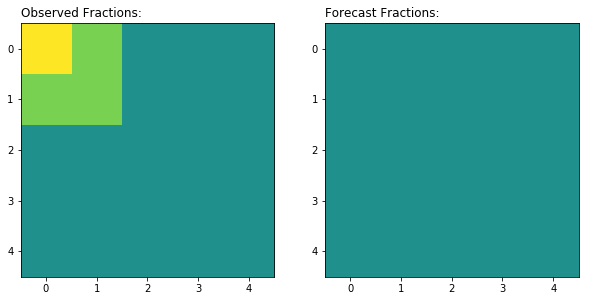

In [105]:
MSE = np.mean((OBS-FXX)**2)
MSE_ref = np.mean(OBS**2 + FXX**2)
FSS = 1 - (MSE/MSE_ref)

print('MSE        :  %.2f' % MSE)
print('MSE_ref    :  %.2f' % MSE_ref)
print('FSS        :  %.2f' % FSS)
print()

BaseRate = .3
FSS_uniform = 0.5 + BaseRate/2

print('  Base Rate: %.02f' % BaseRate)
print('FSS_uniform: %.2f' % FSS_uniform)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.set_title('Observed Fractions:', loc='left')
ax1.imshow(OBS, vmin=0, vmax=1)

ax2.set_title('Forecast Fractions:', loc='left')
ax2.imshow(FXX, vmin=0, vmax=1);

Some FSS characteristics:
- FSS range from 0 to 1.
- Skill asomptopes depends on the forecast bias. For an unbiased forecast, FSS asomptopes to 1 with increasing *n*.
- A perfect forecast of 1 occurs when `MSE=0`. This is only possible for an unbiased forecast.
- 

---
> Abreviations
- `n` : the neighborhood size used to compute fractional areas
- `O(n)`: Fraction of neighborhood with observed condition at every grid point
- `M(n)`: Fraction of neighborhood with forecasted condition at every grid point
- `Nx Ny`: Every grid point in the domain
- `MSE`: Mean Square Error
- `MSE_ref`: skill of a completley random forecast
- `FSS`: Fractions Skill Score

## Useful Forecast

A useful forecast is defined where FSS > FSS_uniform

$$FSS_{uniform} = 0.5 + BaseRate/2$$

### Scenario 1: All Points Observe Condition
If all points observe the condition, then BaseRate==1. FSS_uniform is

---

# Real Example: HRRR Simulated Reflectivity
For the purpose of this demo, the "observed" field will be the HRRR analysis F00.

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy import ndimage

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_HRRR.HRRR_Pando import get_hrrr_variable
from BB_maps.my_basemap import draw_HRRR_map

m = draw_HRRR_map()

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


### Download Data

In [118]:
validDATE = datetime(2019, 5, 1)
fxx = 12

Analysis = get_hrrr_variable(validDATE, variable='REFC:entire')
Forecast = get_hrrr_variable(validDATE-timedelta(hours=fxx), variable='REFC:entire', fxx=fxx)


 >> Dowloading tempfile: ./temp_hrrr_2019050100_f00_REF.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190501/hrrr.t00z.wrfsfcf00.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190501/hrrr.t00z.wrfsfcf00.grib2.idx
 >> Matched a variable:  1:0:d=2019050100:REFC:entire atmosphere:anl:
 >> Byte Range: 0 562678
  Run Date: 2019-05-01 00:00 UTC F00
Valid Date: 2019-05-01 00:00 UTC

 >> Dowloading tempfile: ./temp_hrrr_2019043012_f12_REF.grib2
Oh, good, you requested a date that should be on Pando.
GRIB2 File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190430/hrrr.t12z.wrfsfcf12.grib2
 .idx File: https://pando-rgw01.chpc.utah.edu/hrrr/sfc/20190430/hrrr.t12z.wrfsfcf12.grib2.idx
 >> Matched a variable:  1:0:d=2019043012:REFC:entire atmosphere:12 hour fcst:
 >> Byte Range: 0 600338
  Run Date: 2019-04-30 12:00 UTC F12
Valid Date: 2019-05-01 00:00 UTC


### Generate Binary Fields

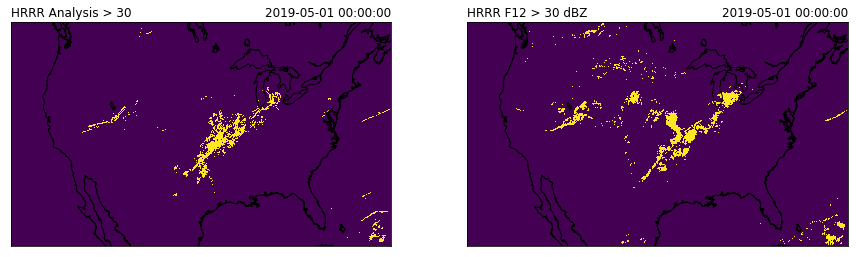

In [149]:
threshold = 30  # dBz

binary_anl = Analysis['value'].data > threshold
binary_fxx = Forecast['value'].data > threshold

# Convert values from boolean to 1 or 0
binary_anl = np.array(binary_anl, dtype=float)
binary_fxx = np.array(binary_fxx, dtype=float)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(Analysis['lon'], Analysis['lat'], binary_anl, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR Analysis > %s' % threshold, loc='left'); plt.title(validDATE, loc='right')

plt.sca(ax2)
m.pcolormesh(Analysis['lon'], Analysis['lat'], binary_fxx, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR F%02d > %s dBZ' % (fxx, threshold), loc='left'); plt.title(validDATE, loc='right');

### Generate Fractions
Note: the large the size of the neighborhood, the longer it takes to run the filter.

In [150]:
def fraction(values):
    return np.sum(values)/np.size(values)

In [151]:
n = 10  # Define size of square neighborhood 

fraction_anl = ndimage.generic_filter(binary_anl, fraction, mode='constant', cval=0, size=n) 
fraction_fxx = ndimage.generic_filter(binary_fxx, fraction, mode='constant', cval=0, size=n)

NOTE: Circular neighborhoods are also easy. You can customize a ndimage.generic_filter footprint...
    
    def radial_footprint(radius):
        """A footprint with the given radius"""
        y,x = np.ogrid[-radius: radius+1, -radius: radius+1]
        footprint = x**2+y**2 <= radius**2
        footprint = 1*footprint.astype(float)
        return footprint
     ndimage.generic_filter(obs_binary, fraction, footprint=radial_footprint(5), mode='constant', cval=0)

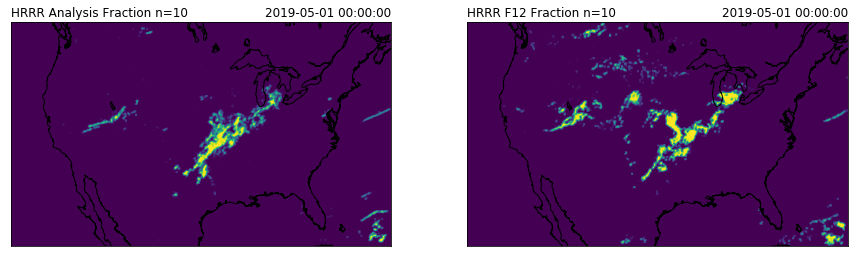

In [152]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
plt.sca(ax1)
m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_anl, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR Analysis Fraction n=%s' % n, loc='left'); plt.title(validDATE, loc='right')

plt.sca(ax2)
m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_fxx, latlon=True, vmin=0, vmax=1)
m.drawcoastlines()
plt.title('HRRR F%02d Fraction n=%s' % (fxx, n), loc='left'); plt.title(validDATE, loc='right');

### Compute Fractions Skill Score (FSS)

In [158]:
MSE = np.mean((fraction_anl - fraction_fxx)**2)
MSE_ref = np.mean(fraction_anl**2) + np.mean(fraction_fxx**2)

FSS = 1 - (MSE/MSE_ref)

print('MSE   : %.2f' % MSE)
print('MSEref: %.2f' % MSE_ref)
print()
print('FSS   : %.2f' % FSS)

MSE   : 0.01
MSEref: 0.02

FSS   : 0.47


#### What is a useful forecast, FSS_uniform?

In [162]:
# Base Rate is the fraction of points with the observed condition
BaseRate = np.sum(binary_anl)/np.size(binary_anl)

FSS_uniform = .5 + BaseRate/2

print('Base Rate  : %.2f' % BaseRate)
print()
print('FSSuniform : %.2f' % FSS_uniform)

Base Rate  : 0.02

FSSuniform : 0.51


### Show FSS for Multiple Neighborhood sizes

n         MSE       MSE_ref   FSS       
1         0.029     0.041     0.28      
5         0.018     0.03      0.39      
10        0.013     0.025     0.47      
20        0.0083    0.02      0.58      


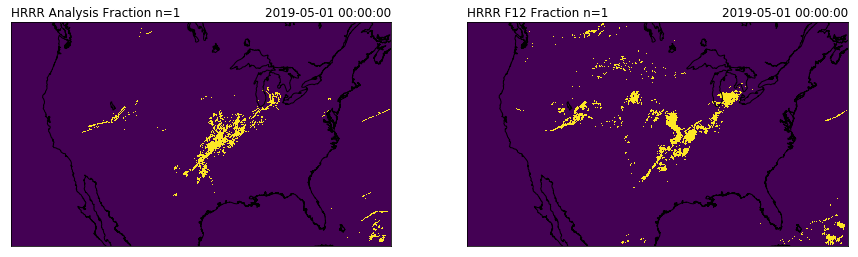

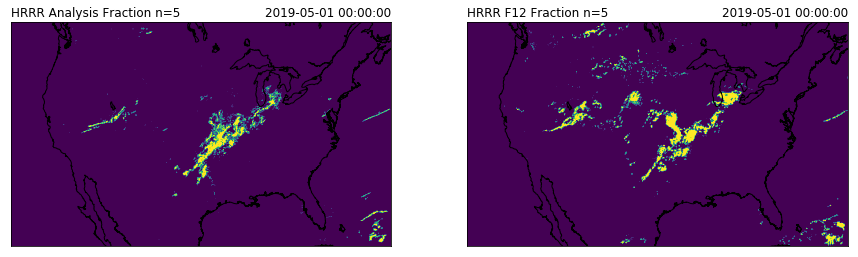

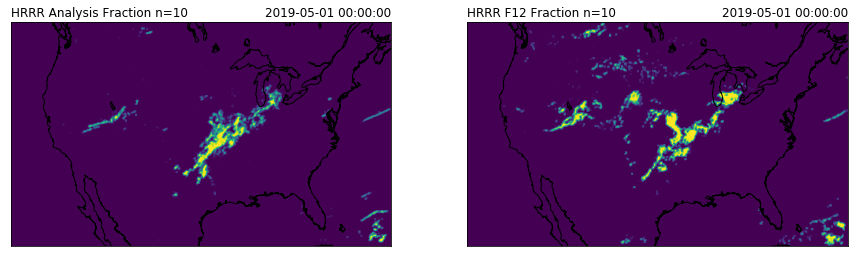

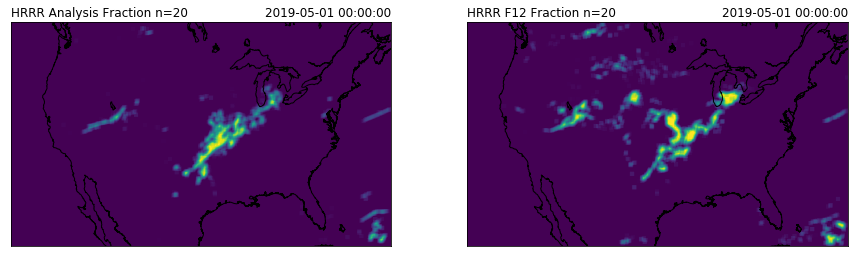

In [182]:
print('{:10}{:10}{:10}{:10}'.format('n', 'MSE', 'MSE_ref', 'FSS'))

for n in [1, 5, 10, 20]:
    fraction_anl = ndimage.generic_filter(binary_anl, fraction, mode='constant', cval=0, size=n) 
    fraction_fxx = ndimage.generic_filter(binary_fxx, fraction, mode='constant', cval=0, size=n)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[15,5])
    plt.sca(ax1)
    m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_anl, latlon=True, vmin=0, vmax=1)
    m.drawcoastlines()
    plt.title('HRRR Analysis Fraction n=%s' % n, loc='left'); plt.title(validDATE, loc='right')

    plt.sca(ax2)
    m.pcolormesh(Analysis['lon'], Analysis['lat'], fraction_fxx, latlon=True, vmin=0, vmax=1)
    m.drawcoastlines()
    plt.title('HRRR F%02d Fraction n=%s' % (fxx, n), loc='left'); plt.title(validDATE, loc='right');

    MSE = np.mean((fraction_anl - fraction_fxx)**2)
    MSE_ref = np.mean(fraction_anl**2) + np.mean(fraction_fxx**2)

    FSS = 1 - (MSE/MSE_ref)

    print('{:<10}{:<10.2}{:<10.2}{:<10.2}'.format(n, MSE, MSE_ref, FSS))